[1/1] train_loss: 0.30299 valid_loss: 0.18329
Validation loss decreased (inf --> 0.183291).  Saving model ...


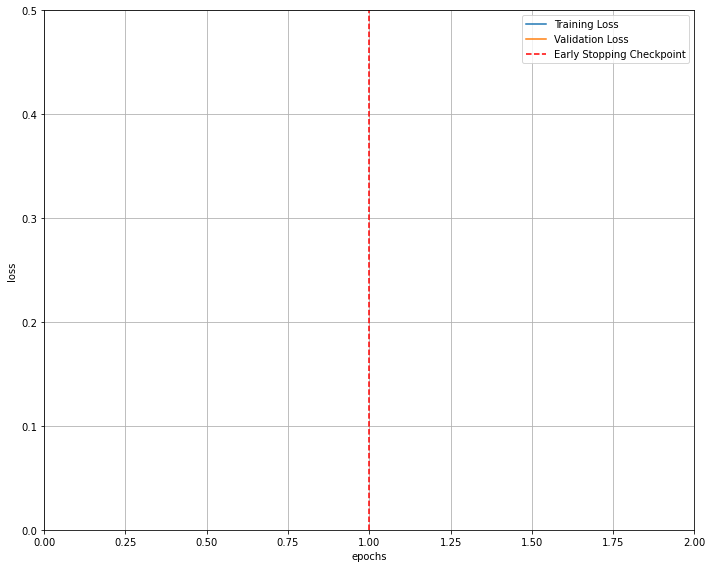

Starting test
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Runnin

'\n### COLLECTING MODEL SPECS\nmodel_specs = {\n    "Experiment_number" : experiment_no,\n    "Test_accuracy" : [test_accuracy],\n    "Patience" : [patience],\n    "Epochs" : [n_epochs],\n    "Batch_size" : [batch_size],\n    "Model_spec" : [model],\n    "Activation_func" : [activation_func],\n    "Optimizer" : [optimizer],\n    "Loss func" : [criterion]\n    \n    }\nresults_df = pd.DataFrame.from_dict(data=model_specs)\nexperiment_no +=1\n#experiments = ["1", "2", "3", "4", "5"]\nall_results = all_results.append(results_df)\n#all_results.insert(0, "Experiments", experiments)\nall_results.to_excel("all_results_task3.xlsx")\n'

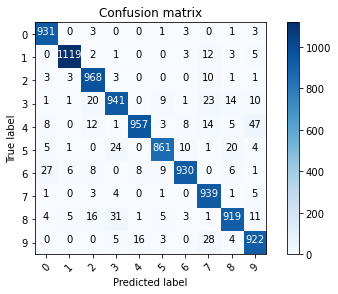

In [3]:
import import_ipynb # if the import causes issues, make sure the module is installed with pip install import_ipynb
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from pytorchtools import EarlyStopping
from torch.utils.data import DataLoader, Dataset
import utils
from sklearn import metrics

def create_datasets(batch_size):
    # WITH EARLY STOPPING, helped by this tutorial:
    # https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb


    valid_size = 0.2

    transform = transforms.ToTensor()

    train_data = datasets.MNIST(root='cnn2data', 
                                train=True,
                                download=True, 
                                transform=transform)

    test_data = datasets.MNIST(root='cnn2data',
                               train=False,
                               download=True,
                               transform=transform)

    # Create indices use for splitting data
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # Use samplers to get training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)
    
    return train_loader, test_loader, valid_loader

##############################################################################
############################# DEFINING MODEL #################################
##############################################################################

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(28 * 28, 128) # 128 baseline
        self.hidden1 = nn.Linear(128, 256)
        self.hidden2 = nn.Linear(256, 256)
        self.hidden3 = nn.Linear(256, 128)
        self.output_layer = nn.Linear(128, 10)
        self.activation = nn.ReLU()
        #self.fc3 = nn.Linear(500, 500)
        #self.fc4 = nn.Linear(500, 300)
        #self.fc5 = nn.Linear(300, 150)
        #self.fc6 = nn.Linear(2048, 10)
        #self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        x = self.activation(self.input_layer(x))
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        x = self.activation(self.hidden3(x))
        x = self.output_layer(x)
        # add hidden layer, with relu activation function
        #x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        # add hidden layer, with relu activation function
        #x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        #x = F.relu(self.fc3(x))
        #x = self.dropout(x)
        #x = F.relu(self.fc4(x))
        #x = self.dropout(x)
        #x = F.relu(self.fc5(x))
        #x = self.dropout(x)
        # add output layer
        #x = self.fc6(x)
        return x

# initialize the NN
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())   


##############################################################################
################## DEFINING TRAIN AND TEST METHODS ###########################
##############################################################################
def train_model(model, batch_size, patience, n_epochs, train_loader, valid_loader):
    # Code (only) for early stopping adapted from:
    # https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb 

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True, delta=0.01)
    
    for epoch in range(1, n_epochs + 1):

        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())


        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())


        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        

        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
       
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

def test(model, test_loader):
        print("Starting test")
        
        all_labels = []
        all_predicted = []
        # Testing the model      
        #self.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                all_labels.append(labels)
                # train is being called when test() is run, so I'm amending the code below to see if it has any effects
                outputs = model.forward(images) # model(images)
                _, predicted = torch.max(outputs.data, 1)
                all_predicted.append(predicted)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
            test_accuracy = (correct / total) * 100
            print('Test Accuracy of the model on the 10000 test images: {} %'.format(test_accuracy))
            return test_accuracy, all_predicted, all_labels

##############################################################################
############################## RUN THE METHODS ###############################
##############################################################################
batch_size = 32
n_epochs = 1
patience = 10
activation_func = "relu"

train_loader, test_loader, valid_loader = create_datasets(batch_size)

model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs, train_loader, valid_loader)

### PLOTTING TRAIN AND VAL LOSS THROUGHOUT TRAINING
# Source: https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')
# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) 
plt.xlim(0, len(train_loss)+1) 
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

### TESTING THE MODEL
test_accuracy, all_predicted, all_labels = test(model, test_loader)
#experiment_no = 1

### GENERATING AND PLOTTING CONFUSION MATRIX
confusionmatrix_exp5, cat_all_preds, cat_all_labels = utils.generate_confusion_matrix(
    all_predicted, all_labels)
utils.plot_confusion_matrix(confusionmatrix_exp5, [0,1,2,3,4,5,6,7,8,9]) 

### COMPUTING PREDICTION QUALITY MEASURES
print(metrics.classification_report(cat_all_preds, cat_all_labels))

"""
### COLLECTING MODEL SPECS
model_specs = {
    "Experiment_number" : experiment_no,
    "Test_accuracy" : [test_accuracy],
    "Patience" : [patience],
    "Epochs" : [n_epochs],
    "Batch_size" : [batch_size],
    "Model_spec" : [model],
    "Activation_func" : [activation_func],
    "Optimizer" : [optimizer],
    "Loss func" : [criterion]
    
    }
results_df = pd.DataFrame.from_dict(data=model_specs)
experiment_no +=1
#experiments = ["1", "2", "3", "4", "5"]
all_results = all_results.append(results_df)
#all_results.insert(0, "Experiments", experiments)
all_results.to_excel("all_results_task3.xlsx")
"""